In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import model.sdes as sdes
import model.generate as generate
import model.table_dnn as table_dnn
import model.util as model_util
from plot.plot import plot_mnist_digits
import torch
import torchvision
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
import os

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

In [3]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

def class_to_class_index_tensor(c):
    """
    Given a tensor of classes, return the corresponding class indices
    as a tensor.
    """
    return torch.argmax(
        (c[:, None] == torch.tensor(classes, device=c.device)).int(), dim=1
    ).to(DEVICE)

In [4]:
models_base_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/"

### Create data loader

In [5]:
# Define the branches
letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
class_to_letter = dict(enumerate(letters))
letter_to_class = {v : k for k, v in class_to_letter.items()}

# classes = [letter_to_class[l] for l in ("A", "V", "Y")]
# branch_defs = [
#     (("A", "V", "Y"), 0.65, 1),
#     (("A",), 0, 0.65),
#     (("V", "Y"), 0.35, 0.65),
#     (("V",), 0, 0.35),
#     (("Y",), 0, 0.35)
# ]

classes = [letter_to_class[l] for l in letters]
branch_defs = [(('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'), 0.5235235235235235, 1), (('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z'), 0.5165165165165165, 0.5235235235235235), (('B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z'), 0.5115115115115115, 0.5165165165165165), (('B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z'), 0.4944944944944945, 0.5115115115115115), (('I', 'J'), 0.4794794794794795, 0.4944944944944945), (('B', 'C', 'D', 'E', 'F', 'G', 'H', 'K', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z'), 0.4724724724724725, 0.4944944944944945), (('B', 'C', 'D', 'E', 'G', 'H', 'K', 'M', 'N', 'O', 'Q', 'R', 'S', 'U', 'X', 'Z'), 0.45645645645645644, 0.4724724724724725), (('F', 'P', 'T', 'V', 'Y'), 0.4364364364364364, 0.4724724724724725), (('B', 'C', 'D', 'E', 'G', 'H', 'K', 'N', 'O', 'Q', 'R', 'S', 'U', 'X', 'Z'), 0.4174174174174174, 0.45645645645645644), (('B', 'C', 'D', 'E', 'G', 'H', 'K', 'N', 'O', 'Q', 'R', 'S', 'X', 'Z'), 0.4134134134134134, 0.4174174174174174), (('B', 'D', 'G', 'H', 'K', 'N', 'O', 'Q', 'R', 'S', 'X', 'Z'), 0.4094094094094094, 0.4134134134134134), (('F', 'T', 'V', 'Y'), 0.4024024024024024, 0.4364364364364364), (('B', 'D', 'G', 'H', 'K', 'O', 'Q', 'R', 'S', 'X', 'Z'), 0.3863863863863864, 0.4094094094094094), (('B', 'G', 'H', 'K', 'O', 'Q', 'R', 'S', 'X', 'Z'), 0.3813813813813814, 0.3863863863863864), (('B', 'G', 'H', 'O', 'Q', 'R', 'S', 'X', 'Z'), 0.3733733733733734, 0.3813813813813814), (('F', 'T', 'Y'), 0.36036036036036034, 0.4024024024024024), (('C', 'E'), 0.3563563563563564, 0.4134134134134134), (('T', 'Y'), 0.3533533533533533, 0.36036036036036034), (('B', 'R', 'S', 'X', 'Z'), 0.35135135135135137, 0.3733733733733734), (('G', 'H', 'O', 'Q'), 0.34134134134134136, 0.3733733733733734), (('B', 'S', 'X', 'Z'), 0.32232232232232233, 0.35135135135135137), (('B', 'S', 'X'), 0.27627627627627627, 0.32232232232232233), (('G', 'H', 'O'), 0.26426426426426425, 0.34134134134134136), (('G', 'O'), 0.25725725725725723, 0.26426426426426425), (('S', 'X'), 0.15615615615615616, 0.27627627627627627), (('W',), 0, 0.5235235235235235), (('A',), 0, 0.5165165165165165), (('L',), 0, 0.5115115115115115), (('J',), 0, 0.4794794794794795), (('I',), 0, 0.4794794794794795), (('M',), 0, 0.45645645645645644), (('P',), 0, 0.4364364364364364), (('U',), 0, 0.4174174174174174), (('N',), 0, 0.4094094094094094), (('V',), 0, 0.4024024024024024), (('D',), 0, 0.3863863863863864), (('K',), 0, 0.3813813813813814), (('F',), 0, 0.36036036036036034), (('E',), 0, 0.3563563563563564), (('C',), 0, 0.3563563563563564), (('Y',), 0, 0.3533533533533533), (('T',), 0, 0.3533533533533533), (('R',), 0, 0.35135135135135137), (('Q',), 0, 0.34134134134134136), (('Z',), 0, 0.32232232232232233), (('B',), 0, 0.27627627627627627), (('H',), 0, 0.26426426426426425), (('G',), 0, 0.25725725725725723), (('O',), 0, 0.25725725725725723), (('S',), 0, 0.15615615615615616), (('X',), 0, 0.15615615615615616)]

branch_defs = [
    (tuple(map(lambda l: letter_to_class[l], trip[0])), trip[1], trip[2])
    for trip in branch_defs
]

input_shape = (1, 28, 28)

In [6]:
class LetterDataset(torch.utils.data.Dataset):
    def __init__(self):
        data_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/data/letter_recognition/letter-recognition.data"
        
        data = []
        targets = []
        with open(data_path, "r") as f:
            for line in f:
                tokens = line.strip().split(",")
                targets.append(tokens[0])
                data.append(np.array(list(map(int, tokens[1:]))))
        self.data = np.stack(data)
        self.targets = np.array([letter_to_class[l] for l in targets])
        
        # Center/normalize the data
        self.data = (self.data - np.mean(self.data, axis=0, keepdims=True)) / \
            np.std(self.data, axis=0, keepdims=True)
        
    def __getitem__(self, index):
        return torch.tensor(self.data[index]).float(), self.targets[index]
        
    def __len__(self):
        return len(self.targets)
    
dataset = LetterDataset()

# Limit classes
inds = np.isin(dataset.targets, classes)
dataset.data = dataset.data[inds]
dataset.targets = dataset.targets[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)
input_shape = next(iter(data_loader))[0].shape[1:]

### Import models

In [7]:
# Define the SDE and import the branched model
sde = sdes.VariancePreservingSDE(0.1, 20, input_shape)

t_limit = 1
branched_model = model_util.load_model(
    table_dnn.MultitaskTabularNet,
    os.path.join(models_base_path, "letters_continuous_allletters/4/epoch_300_ckpt.pth")
).to(DEVICE)

In [8]:
# Import the label-guided model
label_guided_model = model_util.load_model(
    table_dnn.LabelGuidedTabularNet,
    os.path.join(models_base_path, "letters_continuous_allletters_labelguided/1/epoch_100_ckpt.pth")
).to(DEVICE)

### Sample digits

In [9]:
# Sample digits of each class from branched model
branched_samples = {}
for class_to_sample in classes:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_continuous_branched_samples(
        branched_model, sde, class_to_sample, class_time_to_branch_tensor,
        sampler="pc", t_limit=t_limit, num_samples=1000
    ).cpu().numpy()
    branched_samples[class_to_sample] = samples

Sampling class: 0
Sampling class: 1
Sampling class: 2
Sampling class: 3
Sampling class: 4
Sampling class: 5
Sampling class: 6
Sampling class: 7
Sampling class: 8
Sampling class: 9
Sampling class: 10
Sampling class: 11
Sampling class: 12
Sampling class: 13
Sampling class: 14
Sampling class: 15
Sampling class: 16
Sampling class: 17
Sampling class: 18
Sampling class: 19
Sampling class: 20
Sampling class: 21
Sampling class: 22
Sampling class: 23
Sampling class: 24
Sampling class: 25


In [10]:
# Sample digits of each class from label-guided model
label_guided_samples = {}
for class_to_sample in classes:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_continuous_label_guided_samples(
        label_guided_model, sde, class_to_sample, class_to_class_index_tensor,
        sampler="pc", t_limit=t_limit, num_samples=1000
    ).cpu().numpy()
    label_guided_samples[class_to_sample] = samples

Sampling class: 0
Sampling class: 1
Sampling class: 2
Sampling class: 3
Sampling class: 4
Sampling class: 5
Sampling class: 6
Sampling class: 7
Sampling class: 8
Sampling class: 9
Sampling class: 10
Sampling class: 11
Sampling class: 12
Sampling class: 13
Sampling class: 14
Sampling class: 15
Sampling class: 16
Sampling class: 17
Sampling class: 18
Sampling class: 19
Sampling class: 20
Sampling class: 21
Sampling class: 22
Sampling class: 23
Sampling class: 24
Sampling class: 25


In [11]:
# Sample digits from the original dataset
true_samples = {}
for class_to_sample in classes:
    print("Sampling class: %s" % class_to_sample)
    inds = np.where(dataset.targets == class_to_sample)[0]
    sample_inds = np.random.choice(inds, size=700, replace=False)
    samples = dataset.data[sample_inds]
    true_samples[class_to_sample] = samples

Sampling class: 0
Sampling class: 1
Sampling class: 2
Sampling class: 3
Sampling class: 4
Sampling class: 5
Sampling class: 6
Sampling class: 7
Sampling class: 8
Sampling class: 9
Sampling class: 10
Sampling class: 11
Sampling class: 12
Sampling class: 13
Sampling class: 14
Sampling class: 15
Sampling class: 16
Sampling class: 17
Sampling class: 18
Sampling class: 19
Sampling class: 20
Sampling class: 21
Sampling class: 22
Sampling class: 23
Sampling class: 24
Sampling class: 25


### Compute FID

In [12]:
def compute_fid(samples_1, samples_2):
    """
    Computes the Frechet inception distance between two samples of
    objects. Although the two arrays can have any shape (number of
    dimensions must be at least 2), they must be the same shape and
    distance will be computed by flattening anything after the batch
    dimension.
    Arguments:
        `samples_1`: a B x ... array of B samples
        `samples_2`: a B' x ... array of B' samples, in the same shape
            as `samples_1`
    Returns a scalar FID score.
    """
    assert samples_1.shape[1:] == samples_2.shape[1:]
    assert len(samples_1.shape) >= 2
    
    samples_1 = np.reshape(samples_1, (samples_1.shape[0], -1))
    samples_2 = np.reshape(samples_2, (samples_2.shape[0], -1))
    # Shape: B x D
    
    mean_1, cov_1 = np.mean(samples_1, axis=0), np.cov(np.transpose(samples_1))
    mean_2, cov_2 = np.mean(samples_2, axis=0), np.cov(np.transpose(samples_2))
    # Mean shape: D; Covariance matrix shape: D x D
    
    mean_square_norm = np.sum(np.square(mean_1 - mean_2))
    
    # Compute covariance term; because covariance matrices are symmetric,
    # the order of multiplication here doesn't matter
    cov_mean = scipy.linalg.sqrtm(np.matmul(cov_1, cov_2))
    if np.iscomplexobj(cov_mean):
        # Disscard imaginary part if needed
        cov_mean = np.real(cov_mean)
    cov_term = np.trace(cov_1 + cov_2 - (2 * cov_mean))
    
    return mean_square_norm + cov_term

In [13]:
# Compute FID scores
fid_scores = {}
for class_to_sample in classes:
    print("FID of %d" % class_to_sample)
    branched = branched_samples[class_to_sample]
    label_guided = label_guided_samples[class_to_sample]
    true = true_samples[class_to_sample]
    branched_fid = compute_fid(branched, true)
    label_guided_fid = compute_fid(label_guided, true)
    fid_scores[class_to_sample] = (branched_fid, label_guided_fid)
    print("Branched FID: %.4f" % branched_fid)
    print("Label-guided FID: %.4f" % label_guided_fid)

FID of 0
Branched FID: 5.7800
Label-guided FID: 2.0958
FID of 1
Branched FID: 3.2749
Label-guided FID: 2.0429
FID of 2
Branched FID: 2.7166
Label-guided FID: 2.6443
FID of 3
Branched FID: 1.4310
Label-guided FID: 2.6376
FID of 4
Branched FID: 3.1240
Label-guided FID: 2.8403
FID of 5
Branched FID: 2.3095
Label-guided FID: 5.5564
FID of 6
Branched FID: 4.0418
Label-guided FID: 3.1726
FID of 7
Branched FID: 4.0685
Label-guided FID: 3.5111
FID of 8
Branched FID: 9.8645
Label-guided FID: 8.7844
FID of 9
Branched FID: 5.6321
Label-guided FID: 8.3658
FID of 10
Branched FID: 3.0167
Label-guided FID: 1.5736
FID of 11
Branched FID: 9.3857
Label-guided FID: 6.0188
FID of 12
Branched FID: 4.1434
Label-guided FID: 21.1603
FID of 13
Branched FID: 3.7714
Label-guided FID: 8.1759
FID of 14
Branched FID: 2.4687
Label-guided FID: 2.4668
FID of 15
Branched FID: 2.7833
Label-guided FID: 3.9140
FID of 16
Branched FID: 2.9457
Label-guided FID: 6.0455
FID of 17
Branched FID: 3.8043
Label-guided FID: 5.7225
F

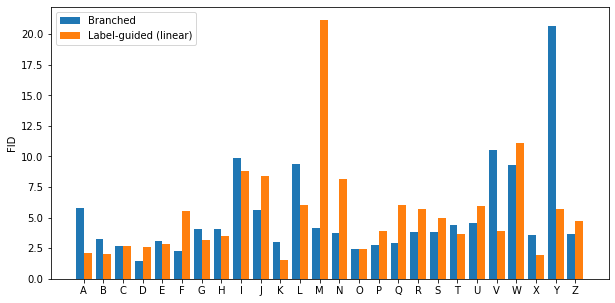

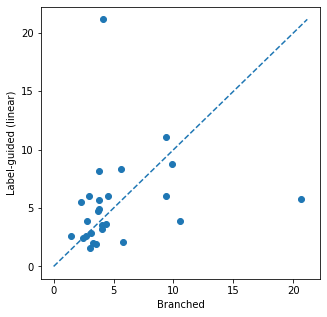

In [14]:
branched_vals, linear_vals = [fid_scores[c][0] for c in classes], [fid_scores[c][1] for c in classes]

fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.4
x = np.arange(len(fid_scores))
ax.bar(x, branched_vals, bar_width, label="Branched")
ax.bar(x + bar_width, linear_vals, bar_width, label="Label-guided (linear)")
ax.set_xticks(x + (bar_width / 2), labels=[class_to_letter[c] for c in classes])
ax.set_ylabel("FID")
# ax.set_ylim((0, 25))
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(branched_vals, linear_vals)
ax.set_xlabel("Branched")
ax.set_ylabel("Label-guided (linear)")
max_val = np.max(branched_vals + linear_vals)
ax.plot((0, max_val), (0, max_val), "--")
plt.show()